### Alpha extension `130/30`

We consider an alpha extension using value and momentum factors. The alpha extension strategy is essentially a `100` long index-tracking strategy (we shifted constituents one month forward, so we essentially take the index weights of the previous months for the current month), combined with a `30/30` equity-market neutral component.

Then, we can consider our `30/30` component to be our "alpha-seeking" component, and could, in isolation, be benchmarked with a cash-holding basis (for example `SOFR`). 

#### Details on leverage and borrow cost

We have a net exposure of `130 + 30 = 160`, so we have a `1.6:1` leverage ratio on invested capital. Therefore, our leverage ratio is $L = 1.6$.

Our levered return is then

$$ R_{\text{levered}} = L \cdot R_{\text{unlevered}} - (L - 1) \cdot c $$

where $c$ is borrow cost, and $R$ is return for a period. We will begin with a `0` borrow cost assumption (for both shorts and leverage), and then slowly build realism.

#### Details on portfolio construction

As stated previously, the `130/30` is split into a `100` index-long + `30/30` equity market neutral. We constrain the equity market neutral component using constrained optimisation with a weight sum of `0.6`, and a long/short constraint. We will track the beta of the portfolio across history, to ensure that we are tracking for $\beta = 1$.

The `30/30` is called an 'alpha overlay'; we overlay the index weights onto our index-tracking long position.

In [2]:
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import os
from cycler import cycler

plt.style.use("dark_background")

load_dotenv('../.env')

db_url = os.getenv('DB_URL')
psql = create_engine(db_url)

In [3]:
alpha_factors = pd.read_sql(
    """
    select * from factor_scores
    """,
    psql
)

# monthly pricing data
price_data = pd.read_sql(
    """
    select * from eom_prices
    """,
    psql
)

# get required returns data
price_data = price_data.sort_values(['ticker', 'date'])
price_data['return'] = price_data.groupby('ticker')['price'].transform(lambda x: x.pct_change())
price_data['t_plus_3_return'] = price_data.groupby('ticker')['price'].transform(lambda x: x.shift(-3) / x - 1)

# constituent data for our russell 1000 proxy
monthly_constituents = pd.read_sql(
    """
    select * from monthly_constituents
    """,
    psql
)

# change to a wide format
wide_alpha = alpha_factors.pivot_table(
    index = ['date', 'ticker'],
    columns = 'factor',
    values = 'score'
).reset_index()

alpha_data = price_data.merge(wide_alpha, how='left', on=['date', 'ticker']).dropna()
alpha_data = alpha_data.merge(monthly_constituents, how='left', on=['date', 'ticker']).dropna()
alpha_data['date'] = pd.to_datetime(alpha_data['date'])

alpha_data = alpha_data.sort_values('date')

# volatility estimation for portfolio optimisation
alpha_data['volatility_est'] = (
    alpha_data
    .groupby('ticker')['return']
    .transform(lambda x: x.rolling(window=12, min_periods=12).std().shift())
)
alpha_data = alpha_data.dropna()

We do a simple inverse volatility portfolio weighting first.

In [8]:
from sklearn.linear_model import Ridge
from scipy.stats.mstats import winsorize
import cvxpy as cp
from pypfopt import EfficientFrontier, risk_models

# our factors
factors = ['EVEBIT', 'EVEBITDA', 'MOMENTUM', 'PB', 'PE', 'PS']
alpha_data = alpha_data.sort_values('date')

dates = alpha_data['date'].unique()
lookback = 3 # 3-month training lookback

alpha_extension_strategy = []
factor_coeffs = []

for i in range(lookback + 4, len(dates)):
    # i - 4, as we take 3-month lookahead returns to train
    tst_end = i - 4
    tst_start = tst_end - lookback
    tst_data = alpha_data[
        (alpha_data['date'] >= dates[tst_start]) &
        (alpha_data['date'] <= dates[tst_end])
    ].copy()

    # get training for alpha model
    X_tr = tst_data[factors].apply(lambda col: winsorize(col, limits=[0.05, 0.05]).data)
    y_tr = winsorize(tst_data['t_plus_3_return'], limits=[0.01, 0.01])
    
    # get the alpha model
    alpha_model = Ridge(alpha=1.0)
    alpha_model.fit(X_tr, y_tr)

    # now get the current months data
    tst_data = alpha_data[alpha_data['date'] == dates[i]].copy()
    X_tst = tst_data[factors].apply(lambda col: np.asarray(winsorize(col, limits=[0.05, 0.05]).data))
    tst_data['pred_return'] = alpha_model.predict(X_tst)

    # long-only index tracking weights first
    index_w= tst_data['index_weight']

    # inverse volatility weighting
    inv_vol = 1 / tst_data['volatility_est']
    raw_scores = tst_data['pred_return'] * inv_vol

    raw_scores = raw_scores - raw_scores.mean()
    overlay_weights = 0.6 * raw_scores / raw_scores.abs().sum()
    
    # alpha weights
    alpha_w = index_w + overlay_weights
    alpha_extension_strategy.append({
        'date': dates[i],
        'index': sum(index_w * tst_data['return']),
        'alpha': sum(alpha_w * tst_data['return'])
    })

    coeff_dict = dict(zip(factors, alpha_model.coef_))
    coeff_dict['intercept'] = alpha_model.intercept_
    coeff_dict['date'] = dates[i]
    factor_coeffs.append(coeff_dict)

alpha_extension_strategy_df = pd.DataFrame(alpha_extension_strategy)
factor_coeffs_df = pd.DataFrame(factor_coeffs)

In [13]:
alpha_extension_strategy_df['index_cum_return'] = (1 + alpha_extension_strategy_df['index']).cumprod() - 1
alpha_extension_strategy_df['alpha_cum_return'] = (1 + alpha_extension_strategy_df['alpha']).cumprod() - 1

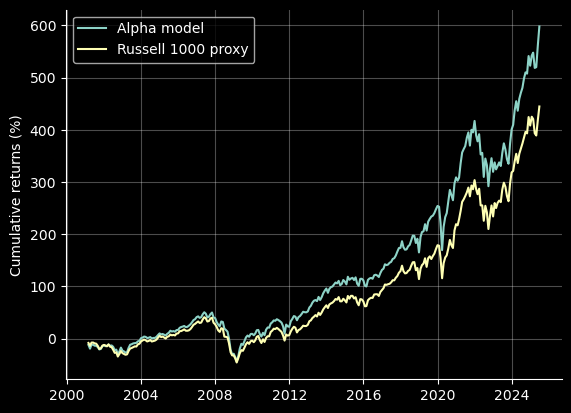

In [14]:
plt.plot(alpha_extension_strategy_df['date'], alpha_extension_strategy_df['alpha_cum_return'] * 100, label='Alpha model')
plt.plot(alpha_extension_strategy_df['date'], alpha_extension_strategy_df['index_cum_return'] * 100, label='Russell 1000 proxy')
sns.despine()
plt.ylabel('Cumulative returns (%)')
plt.grid(alpha = 0.3)
plt.legend()

So the alpha model (without transaction costs, borrow costs, etc.) outperforms the index over our history! That's a cool result - and we see some consistent out performance throughout the entire history (`2020` seems to be a bad drawdown). Let us consider transaction costs of `5` bps per transaction. Let us consider what the performance post-transaction costs are.

In [15]:
alpha_extension_strategy_df['alpha_minus_tc'] = alpha_extension_strategy_df['alpha'] - 0.0005
alpha_extension_strategy_df['alpha_cum_return_minus_tc'] = (1 + alpha_extension_strategy_df['alpha_minus_tc']).cumprod() - 1

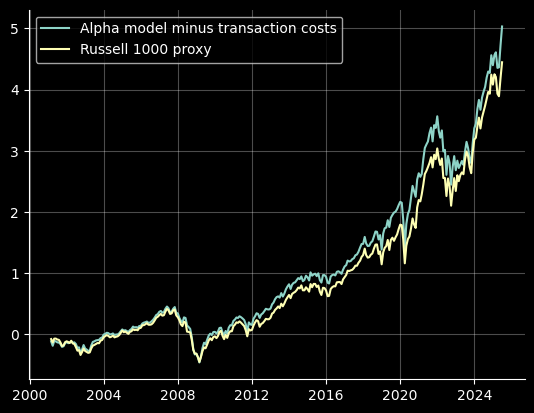

In [73]:
plt.plot(alpha_extension_strategy_df['date'], alpha_extension_strategy_df['alpha_cum_return_minus_tc'], label='Alpha model minus transaction costs')
plt.plot(alpha_extension_strategy_df['date'], alpha_extension_strategy_df['index_cum_return'], label='Russell 1000 proxy')
plt.grid(alpha = 0.3)
sns.despine()
plt.legend()

In [98]:
sharpe = (alpha_extension_strategy_df['alpha_minus_tc'].mean() * 12) / \
        (alpha_extension_strategy_df['alpha_minus_tc'].std() * np.sqrt(12))
mean_ann_return = alpha_extension_strategy_df['alpha_minus_tc'].mean() * 12
mean_ann_vol = alpha_extension_strategy_df['alpha_minus_tc'].std() * np.sqrt(12)

print(f'Sharpe: {round(sharpe, 2)}')
print(f'Mean annualised return: {round(mean_ann_return, 2) * 100}%')
print(f'Mean annualised volatility: {round(mean_ann_vol, 2) * 100}%')

Sharpe: 0.51
Mean annualised return: 9.0%
Mean annualised volatility: 17.0%


Text(0, 0.5, 'Overperformance relative to index per-month (%)')

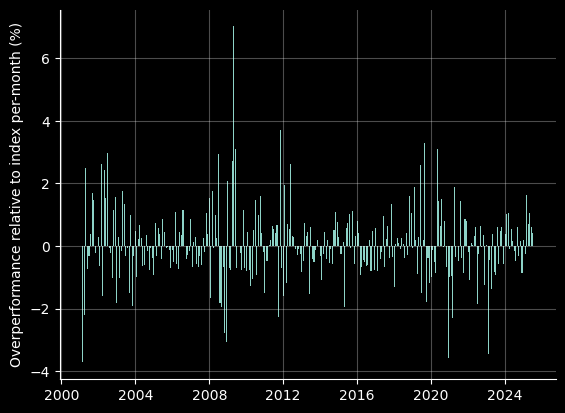

In [ ]:
# get overperformance bar chart

alpha_extension_strategy_df['overperformance_post_tc'] = alpha_extension_strategy_df['alpha_minus_tc'] - alpha_extension_strategy_df['index']

plt.bar(alpha_extension_strategy_df['date'], alpha_extension_strategy_df['overperformance_post_tc'] * 100, width=20)
plt.grid(alpha=0.3)
sns.despine()
plt.ylabel('Overperformance relative to index per-month (%)')

#### Tracking betas

We now consider the rolling 12-month beta between the alpha strategy and the index.

In [107]:
rolling_cov = alpha_extension_strategy_df['alpha_minus_tc'].rolling(window=12).cov(alpha_extension_strategy_df['index'])
rolling_var = alpha_extension_strategy_df['index'].rolling(window=12).var()
rolling_beta = rolling_cov / rolling_var

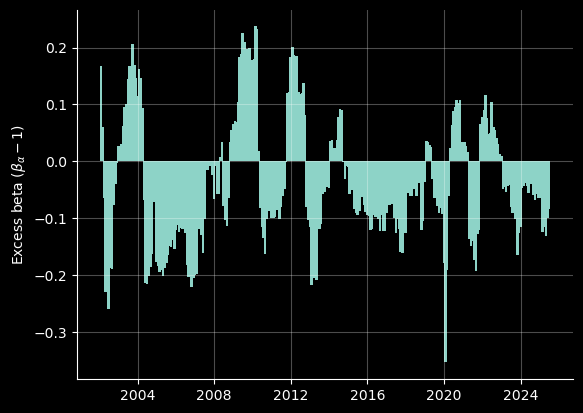

In [116]:
plt.bar(alpha_extension_strategy_df['date'], rolling_beta - 1, width=50)
plt.ylabel('Excess beta ($\\beta_{\\alpha} - 1$)')
plt.grid(alpha=0.3)
sns.despine()

#### Factor attribution

In [23]:
alpha_extension_strategy_df

,date,index,alpha,index_cum_return,alpha_cum_return,alpha_minus_tc,alpha_cum_return_minus_tc
0,2001-02-28,-0.082342,-0.119073,-0.082342,-0.119073,-0.119573,-0.119573
1,2001-03-31,-0.060058,-0.081769,-0.137454,-0.191106,-0.082269,-0.192005
2,2001-04-30,0.072220,0.097615,-0.075161,-0.112146,0.097115,-0.113537
3,2001-05-31,0.001050,-0.005798,-0.074190,-0.117293,-0.006298,-0.119119
4,2001-06-30,-0.016687,-0.019257,-0.089639,-0.134291,-0.019757,-0.136523
...,...,...,...,...,...,...,...
288,2025-02-28,-0.008419,0.008477,4.206361,5.477764,0.007977,4.610217
289,2025-03-31,-0.052496,-0.045065,3.933048,5.185844,-0.045565,4.354588
290,2025-04-30,-0.008480,0.002445,3.891214,5.200966,0.001945,4.365000
291,2025-05-31,0.060793,0.067364,4.188565,5.618685,0.066864,4.723724


Text(0, 0.5, 'Factor coefficient in model')

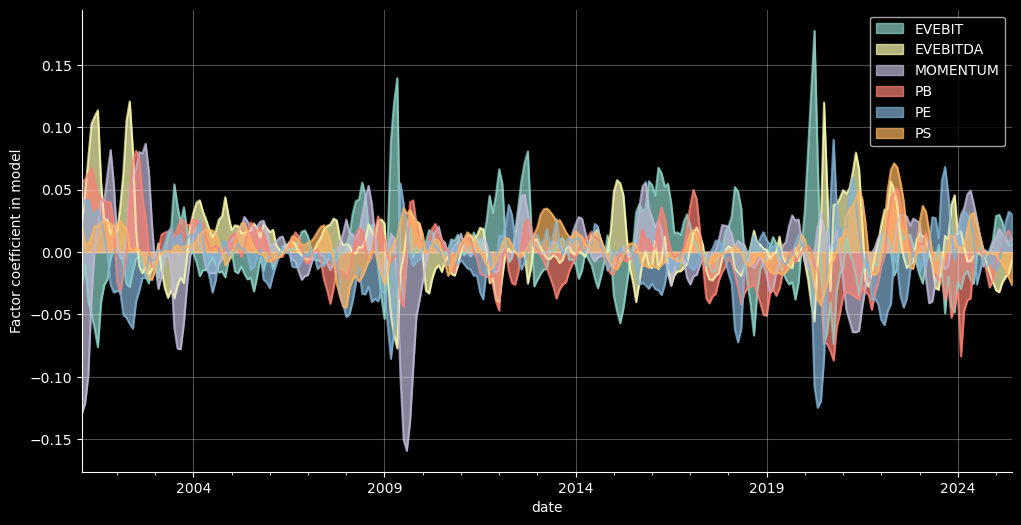

In [33]:
# reshape so that 'date' is the index and factors are columns
coeffs_wide = factor_coeffs_df.set_index('date')[factors]

# area plot
coeffs_wide.plot.area(figsize=(12,6), alpha=0.7, stacked=False)
sns.despine()
plt.grid(alpha=0.3)
plt.ylabel('Factor coefficient in model')